In [1]:
import sys
from pathlib import Path
import operator
from pydantic import BaseModel, Field
import typing as t
from langgraph.graph import StateGraph, START, END
from langgraph.constants import Send
from langchain_core.messages import HumanMessage, SystemMessage

sys.path.append(str(Path().cwd().parent))

from llm_experiments.chat import instantiate_chat

In [2]:
class Section(BaseModel):
    name: str = Field(description="the name for this section of the report")
    description: str = Field(description="brief overview of the main topics and concepts to be covered in this section")

In [3]:
model = instantiate_chat("4o-mini")

In [4]:
class Sections(BaseModel):
    sections: list[Section] = Field(description="sections of the report")

planner = model.with_structured_output(Sections)

In [5]:
class State(t.TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: t.Annotated[list, operator.add]
    final_report: str

def orchestrator(state: State):
    report_sections = planner.invoke(
        [
            SystemMessage(content="generate a plan for the report"),
            HumanMessage(content=f"here is the report topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}

In [6]:
class WorkerState(t.TypedDict):
    section: Section
    completed_sections: t.Annotated[list, operator.add]


def llm_call(state: WorkerState):
    section = model.invoke(
        [
            SystemMessage(content="write a report section following the provided name and description. include no preamble for each section. use markdown formatting."),
            HumanMessage(content=f"here is the section name: {state['section'].name} and description: {state['section'].description}"),
        ]
    )
    return {"completed_sections": [section.content]}

In [7]:
def synthesizer(state: State):
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n--\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

In [8]:
def assign_workers(state: State):
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [9]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

chain = builder.compile()

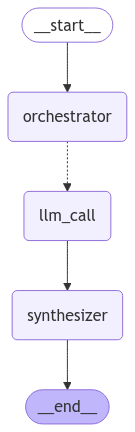

In [10]:
from IPython.display import display, Image

display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
state = {"topic": "the impact of ai on the future of work"}

chain.invoke(state)

{'topic': 'the impact of ai on the future of work',
 'sections': [Section(name='Introduction', description="An overview of the report's purpose, the significance of studying AI's impact on work, and a brief introduction to AI technologies."),
  Section(name='Historical Context', description='A review of the evolution of AI technologies and their previous impacts on the workplace, including a discussion of past technological revolutions.'),
  Section(name='Current Applications of AI in the Workplace', description='An exploration of how AI is currently being utilized in various industries, such as finance, healthcare, and manufacturing, and examples of AI tools and applications.'),
  Section(name='Benefits of AI in the Workplace', description='An assessment of the potential advantages that AI brings to businesses, including increased productivity, improved decision-making, and enhanced customer experiences.'),
  Section(name='Challenges and Concerns', description='An examination of the p